# March Madness and Analytics:

## How Correlated are the Strengths the Men's and Women's NCAA Basketball Teams?

We were watching the first weekend of the NCAA Division 1 Basketball Tournaments, switching back and forth between the men and the women. My wife asked, "Doesn't it seem like we're watching teams from the same schools?" We wondered whether it was the case that having a strong men's team implies that a school also has a strong women's team.

Clearly this was calling out for some data analysis in Python!

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

I downloaded Massey Ratings to the csv files `Massey_men_d1.csv` and `Massey_women_d1.csv` 
from [here](https://www.masseyratings.com/cb/ncaa-d1/ratings) for the men and
from [here](https://www.masseyratings.com/cbw/ncaa-d1/ratings) for the women. The *rating* is a continuous 
numerical variable, and it is accompanied by a *ranking* according to those values. You can read on the Massey Ratings site how they derive the ratings, but we are only interested in the ranking. 

In [4]:
df_mens_ratings = pd.read_csv('Massey_men_d1.csv',usecols=['Team','Rat'],index_col='Team')\
.rename(columns={'Rat':'Ranking'})

df_womens_ratings = pd.read_csv('Massey_women_d1.csv',usecols=['Team','Rat'],index_col='Team')\
.rename(columns={'Rat':'Ranking'})

In [5]:
df_mens_ratings.sample(5).sort_values('Ranking')

,Ranking
Team,
Syracuse,35
Oral Roberts,123
E Kentucky,171
Lafayette,233
ULM,272


In [6]:
df_womens_ratings.sample(5).sort_values('Ranking')

,Ranking
Team,
Kansas,93
Marist,153
Cleveland St,155
Louisiana,159
Navy,254


The next steps are to join the two dataframes using an outer join to retain all of the teams. However, some schools have only one D-I basketball program; so this introduces some missing values. We fill these in with an artifical number which is one more than the worst ranking of any existing program by gender. 

In [7]:
df_combined = df_mens_ratings.merge(df_womens_ratings,on='Team',how='outer',suffixes=['_Men','_Women'])

In [8]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358 entries, Gonzaga to MD E Shore
Data columns (total 2 columns):
Ranking_Men      347 non-null float64
Ranking_Women    355 non-null float64
dtypes: float64(2)
memory usage: 8.4+ KB


In [9]:
df_combined[df_combined.Ranking_Men.isna() | df_combined.Ranking_Women.isna()]

,Ranking_Men,Ranking_Women
Team,,
VMI,185.0,NaN
Citadel,216.0,NaN
TN Martin,325.0,NaN
Princeton,NaN,58.0
Mid,NaN,99.0
Penn,NaN,108.0
Yale,NaN,121.0
Harvard,NaN,136.0
Columbia,NaN,144.0


In [10]:
df_combined.Ranking_Women = df_combined.Ranking_Women.fillna(df_combined.Ranking_Women.max() + 1)
df_combined.Ranking_Men = df_combined.Ranking_Men.fillna(df_combined.Ranking_Men.max() + 1)

In [11]:
df_combined[(df_combined.Ranking_Men == df_combined.Ranking_Men.max()) | (df_combined.Ranking_Women == df_combined.Ranking_Women.max())]

,Ranking_Men,Ranking_Women
Team,,
VMI,185.0,356.0
Citadel,216.0,356.0
TN Martin,325.0,356.0
Princeton,348.0,58.0
Mid,348.0,99.0
Penn,348.0,108.0
Yale,348.0,121.0
Harvard,348.0,136.0
Columbia,348.0,144.0


## Rank Correlation

Now that we have a combined dataframe, let's generate a scatterplot to visulaize the relationship between the rankings of men's and women's programs.

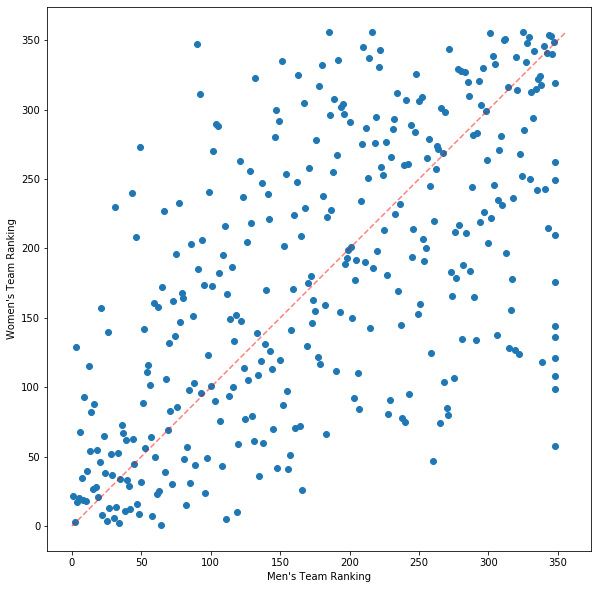

In [12]:
t = np.linspace(0,1,101)

plt.figure(figsize=(10,10))
plt.scatter(df_combined.Ranking_Men, df_combined.Ranking_Women)
plt.plot(356*t, 356*t,'--r',alpha=0.5)
plt.xlabel("Men's Team Ranking")
plt.ylabel("Women's Team Ranking")
plt.axis('square');

The scatterplot shows a clear relationship between the rankings of men's teams and women's teams --- a positive correlation as we suspected.  How do we quantify what we see qualitatively?  

Kendall's tau is used to measure rank correlation.  Like Pearson's coefficient of correlation (usually denoted by _r_), Kendall's tau is a numeric quantity taking values between -1 and 1 where +1 indicates a perfect, positive correlation and -1 indicates a perfect, negative correlation.  However, Kendall's tau is computed in very differently from Pearson's r.

In the case of tau, we look at rankings for pairs of observations. Consider this subset of the dataframe using three randomly chose universities:

In [13]:
# This would truly be random:
# df_combined.sample(3)

In [14]:
# Three not so random schools.
df_combined.loc[['Minnesota', 'Georgia Tech','Wisconsin']]

,Ranking_Men,Ranking_Women
Team,,
Minnesota,51.0,89.0
Georgia Tech,41.0,29.0
Wisconsin,12.0,115.0


Note that Georgia Tech's teams both have better rankings than Minnesota's teams. These rankings are called *concordant*, i.e. they are in harmony. On the other hand, Winsconsin's men have a better ranking than Georgia Tech's while the Wisconsin women's team is ranked worse than Georgia Tech women's team. Those rankings are called *discordant*; they disagree.  Kendall's tau is computed by taking all pairs of observations and comparing the rankings, counting the concordant and discordant pairs.
$$
\tau = \frac{\textrm{# concordant pairs} - \textrm{# discordant pairs}}{\textrm{# all pairs}}
$$

Tau reminds me of *hitting percentage* in volleyball which is computed as (kills - errors)/attempts.

Of course, there is a function in pandas that computes this for us. (The output is a dataframe; you can always extract the individual values.)

In [15]:
df_combined[['Ranking_Men','Ranking_Women']].corr('kendall')

,Ranking_Men,Ranking_Women
Ranking_Men,1.0000,0.4365
Ranking_Women,0.4365,1.0000


## Tournament Appearances: A Binary Approach

We note that there appears to be a strong cluster of points in the lowere left-hand corner of the scatterplot above.

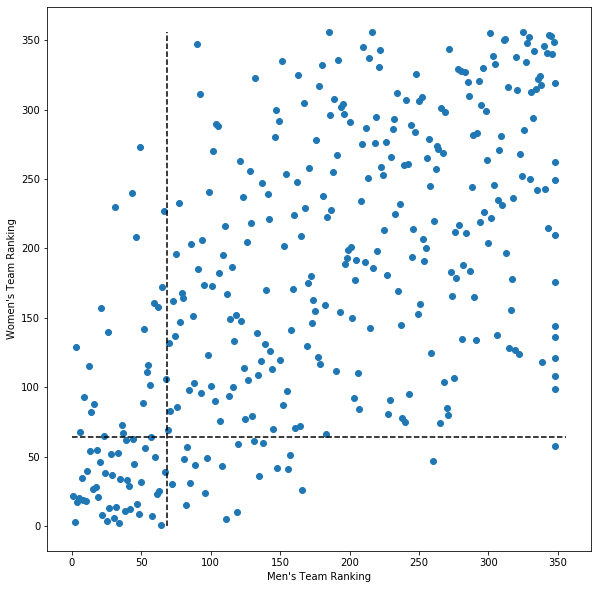

In [16]:
t = np.linspace(0,1,101)

plt.figure(figsize=(10,10))
plt.scatter(df_combined.Ranking_Men, df_combined.Ranking_Women)
plt.plot(68.5*np.ones(t.shape), 356*t,'--k')
plt.plot(356*t, 64.5*np.ones(t.shape),'--k')
plt.xlabel("Men's Team Ranking")
plt.ylabel("Women's Team Ranking")
plt.axis('square');

Here I have drawn in a vertical line that separates the men's programs into two groups: one containing the teams with the top 68 ratings and its complement. I have also drawn a horizontal line that  separates the women's programs into two groups: one containing the teams with the top 64 ratings and its complement. Note the higher density of points in the lower left-hand portion and the relative sparsity of the lower right-hand and upper left-hand portions.

Let's create new binary variables and count programs in each quadrant.

In [17]:
df_combined['Top_64_Womens_Team'] = (df_combined.Ranking_Women < 65)
df_combined['Top_68_Mens_Team'] = (df_combined.Ranking_Men < 69)
df_combined.pivot_table(index ='Top_64_Womens_Team',
                        columns='Top_68_Mens_Team',
                        values='Ranking_Men', 
                        aggfunc='count')

Top_68_Mens_Team,False,True
Top_64_Womens_Team,,
False,269,25
True,21,43


We see that 43 schools have teams with high ranks. Of course the top-ranked teams do not necessarily get into the tournament, but we will postpone any discussion of tournament team selection for now.  Instead, let's import lists of schools that actually made the tournament.

In [18]:
df_womens_field = pd.read_csv('tournament_women.csv')
df_womens_field['Womens_Field'] = True
df_mens_field = pd.read_csv('tournament_men.csv')
df_mens_field['Mens_Field'] = True

In [19]:
df_combined_plus = df_combined.merge(df_womens_field,on='Team',how='outer')\
.merge(df_mens_field,on='Team',how='outer')\
.fillna(False)

Now we can compare the women's field to the men's field.

In [20]:
df_combined_plus.pivot_table(index ='Womens_Field',columns='Mens_Field',values='Ranking_Men', aggfunc='count')

Mens_Field,False,True
Womens_Field,,
False,251,43
True,39,25


In [21]:
25/68, 25/64, 276/358

(0.36764705882352944, 0.390625, 0.770949720670391)

We see that 25 schools with teams in the women's field also have teams in the men's field. Consider using the variable `Womens_Field` to predict the value of `Mens_Field`: as such it has a *recall* of 25/68 (0.368) and a *precision* of 25/64 (0.391) and an accuracy of 276/358 (0.771).

From a stats perspective, we can compute the chi-squared statistic. Here we see that the Chi-squared value is 18.7 for 1 degree of freedom, and the p-value is extremely small at 1.5e-05.  See the documentation at [scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) for details.

In [22]:
from scipy.stats import chi2_contingency
chi2_contingency(df_combined_plus.pivot_table(index ='Womens_Field',
                                              columns='Mens_Field',
                                              values='Ranking_Men',
                                              aggfunc='count').values)

(18.84069047338763,
 1.4210296580948978e-05,
 1,
 array([[238.15642458,  55.84357542],
        [ 51.84357542,  12.15642458]]))

### Do the best teams make the tournaments?

You can also examine the contingency tables showing what fraction of the top-ranked teams also made the tournaments.  How you interpret this is a matter of perspective. A full 70% of the top-ranked men's teams and 67% of the top-ranked women's teams make the tournament, and that seems pretty good ... unless you are a fan of one of the 20 men's or 21 women's teams that did not.

In [23]:
df_combined_plus.pivot_table(index ='Top_68_Mens_Team',
                             columns='Mens_Field',
                             values='Ranking_Men', 
                             aggfunc='count')

Mens_Field,False,True
Top_68_Mens_Team,,
False,270,20
True,20,48


In [24]:
df_combined_plus.pivot_table(index ='Top_64_Womens_Team',
                             columns='Womens_Field',
                             values='Ranking_Women',
                             aggfunc='count')

Womens_Field,False,True
Top_64_Womens_Team,,
False,273,21
True,21,43


### How were the teams ranked?
Here are some additional `groupby` objects, plots and ROC Curves (for good measure) showing the distribution of the rankings for team's that made the tournament versus those that did not.

In [25]:
df_combined_plus.groupby('Mens_Field').Ranking_Men.describe()

,count,mean,std,min,25%,50%,75%,max
Mens_Field,,,,,,,,
False,290.0,207.606897,90.124120,36.0,132.25,211.5,285.75,348.0
True,68.0,58.823529,59.585369,1.0,17.75,34.5,80.25,236.0


In [26]:
df_combined_plus[df_combined_plus.Ranking_Men==236]

,Team,Ranking_Men,Ranking_Women,Top_64_Womens_Team,Top_68_Mens_Team,Womens_Field,Mens_Field
235,Mt St Mary's,236.0,232.0,False,False,True,True


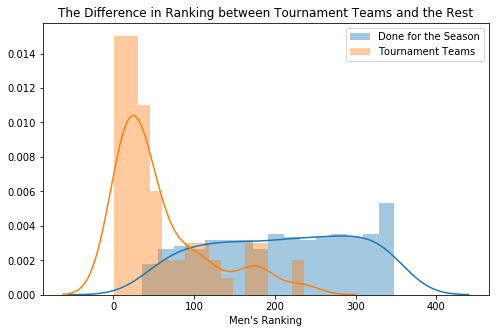

In [27]:
plt.figure(figsize=(8,5))
df_combined_plus.groupby('Mens_Field').apply(lambda x: sns.distplot(x.Ranking_Men,kde=True,bins=16));
plt.legend(['Done for the Season','Tournament Teams']);
plt.xlabel("Men's Ranking")
plt.title("The Difference in Ranking between Tournament Teams and the Rest");

In [28]:
df_combined_plus.groupby('Womens_Field').Ranking_Women.describe()

,count,mean,std,min,25%,50%,75%,max
Womens_Field,,,,,,,,
False,294.0,205.404762,91.963579,19.0,129.50,208.5,284.75,356.0
True,64.0,60.453125,61.742921,1.0,16.75,34.5,90.50,234.0


In [29]:
df_combined_plus[df_combined_plus.Ranking_Women==234]

,Team,Ranking_Men,Ranking_Women,Top_64_Womens_Team,Top_68_Mens_Team,Womens_Field,Mens_Field
207,Utah Valley,208.0,234.0,False,False,True,False


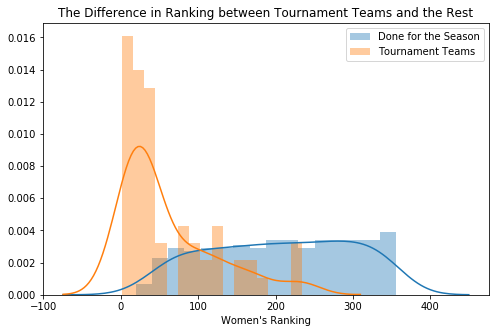

In [30]:
plt.figure(figsize=(8,5))
df_combined_plus.groupby('Womens_Field').apply(lambda x: sns.distplot(x.Ranking_Women,kde=True,bins=16));
plt.legend(['Done for the Season','Tournament Teams']);
plt.xlabel("Women's Ranking")
plt.title("The Difference in Ranking between Tournament Teams and the Rest");

## How should we use Rankings to assess the likelihood of making the tournament?

A team's ranking should tell us how likely they are to make the tournament.  Consider the ROC Curves.  The Youden Index is the point at which the ROC curve is the highest above the digonal line where the True Positive Rate equals the False Positive Rate (y=x).  We can compute the value of the Youden Index and find the corresponding values of the ranking as well as the TPR and FPR.  

The Youden Index is also the point at which the "slope" of the ROC curve is approximately 1, or where you are accumulating as many false positives as true positives as you vary the underlying parameter -- in this case the ranking.  This may be a good choice for setting a threshold for using the ranking for predicting who makes the tournament, but there might be others. One needs to assess the recall and precision values as well depending upon your objectives.

For example the F-score is one attempt to balance recall and precision. It is the harmonic mean of the two metrics. The F-beta score is a weighted harmonic mean which allows one to put more or less weight on recall relative to  precision.

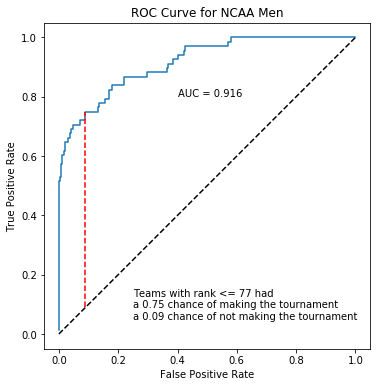

In [31]:
# ranks are just the sequence from 1 to 348
ranks = np.array(df_combined_plus.sort_values('Ranking_Men').Ranking_Men)

# Define the true/false positives and true/false positive rates. 
tp = np.array(df_combined_plus.sort_values('Ranking_Men').Mens_Field.cumsum())
fp = np.array((1 - df_combined_plus.sort_values('Ranking_Men').Mens_Field).cumsum())
tpr = tp/df_combined_plus.Mens_Field.sum()
fpr = fp/(1 - df_combined_plus.Mens_Field).sum()

# To compute the AUC we use "midpoint rule"
# However, the ROC curve consists of horizontal and vertical 
# line segments; so we could have used either right or left endpoints.
y = (tpr[:-1] + tpr[1:])/2
delta_x = np.diff(fpr)
auc = (y*delta_x).sum()

# The Youden index is the point where the ROC curve is highest above
# the diagonal.
youden = tpr - fpr
youden_idx = list(youden).index(youden.max())
tpr_youden = tpr[youden_idx]
fpr_youden = fpr[youden_idx]

# Now we plot the TPR against the FPR to get the ROC curve.
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr);

# Add the diagonal line and ...
plt.plot(fpr,fpr,'--k');

# drop a vertical from the ROC curve at the Youden index.
plt.plot([fpr_youden,fpr_youden],[fpr_youden,tpr_youden],'--r');

# Annotate the plot with the AUC and some info about the Youden index.
plt.text(.4, .8,f'AUC = {auc:.3f}')
plt.text(0.25,0.05, f'Teams with rank <= {youden_idx+1:.0f} had\n' +\
         f'a {tpr_youden:.2f} chance of making the tournament\n' + \
         f'a {fpr_youden:.2f} chance of not making the tournament')

# Add labels and title.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NCAA Men')
plt.axis('square');

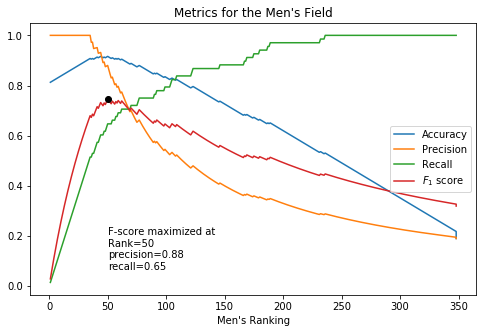

In [32]:
# Compute the false/true negatives.
fn = df_combined_plus.Mens_Field.sum()- tp
tn = (1 - df_combined_plus.Mens_Field).sum() - fp

# We use the newly computed values to compute metrics:
accuracy = (tp + tn)/(tp + fp + tn + fn)
precision = tp/(tp + fp) + 1e-6
recall = tp/(tp + fn) + 1e-6
f_score = 2/((1/precision) + (1/recall))

# Find the place where the F-score is maximized.
f_idx = list(f_score).index(f_score.max())

# Plot metrics.
plt.figure(figsize=(8,5))
plt.plot(ranks,accuracy,label='Accuracy')
plt.plot(ranks,precision,label='Precision')
plt.plot(ranks,recall,label='Recall')
plt.plot(ranks,f_score,label='$F_1$ score')

# Mark the maximum F-score
plt.plot(ranks[f_idx],f_score[f_idx],'ok')

# Annotate the plots
plt.text(ranks[f_idx],0.02,f'F-score maximized at \nRank={ranks[f_idx]:.0f}\n' +
        f'precision={precision[f_idx]:.2f}\n' +
        f'recall={recall[f_idx]:.2f}\n')

# Label the plot.
plt.legend(loc=5);
plt.xlabel("Men's Ranking");
plt.title("Metrics for the Men's Field");

The Youden index is quite high, suggesting that we forecast that a men's team make the tournament whenever the ranking is 77 or lower.  Since there are only 68 teams in the tournament, that does seem to be high. On the other hand, the F-score is maximized at a much lower rank of 50!

We do the same analysis for the women's teams below.

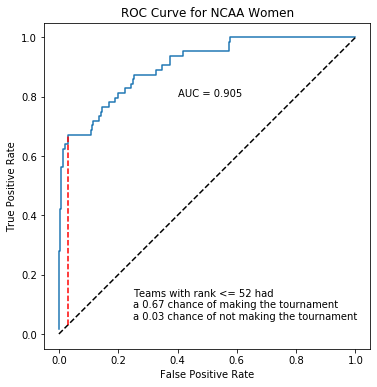

In [33]:
# ranks are just the sequence from 1 to 348
ranks = np.array(df_combined_plus.sort_values('Ranking_Women').Ranking_Women)
                 
# Define the true/false positives and true/false positive rates. 
tp = np.array(df_combined_plus.sort_values('Ranking_Women').Womens_Field.cumsum())
fp = np.array((1 - df_combined_plus.sort_values('Ranking_Women').Womens_Field).cumsum())
tpr = tp/df_combined_plus.Womens_Field.sum()
fpr = fp/(1 - df_combined_plus.Womens_Field).sum()

# To compute the AUC we use "midpoint rule"
# However, the ROC curve consists of horizontal and vertical 
# line segments; so we could have used either right or left endpoints.
y = (tpr[:-1] + tpr[1:])/2
delta_x = np.diff(fpr)
auc = (y*delta_x).sum()
youden = tpr - fpr
youden_idx = list(youden).index(youden.max())

# The Youden index is the point where the ROC curve is highest above
# the diagonal.
tpr_youden = tpr[youden_idx]
fpr_youden = fpr[youden_idx]

# Now we plot the TPR against the FPR to get the ROC curve.
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr);

# Add the diagonal line and ...
plt.plot(fpr,fpr,'--k');

# drop a vertical from the ROC curve at the Youden index.
plt.plot([fpr_youden,fpr_youden],[fpr_youden,tpr_youden],'--r');

# Annotate the plot with the AUC and some info about the Youden index.
plt.text(.4, .8,f'AUC = {auc:.3f}')
plt.text(0.25,0.05, f'Teams with rank <= {youden_idx+1:.0f} had\n' +\
         f'a {tpr_youden:.2f} chance of making the tournament\n' + \
         f'a {fpr_youden:.2f} chance of not making the tournament')

# Add labels and title.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NCAA Women')
plt.axis('square');

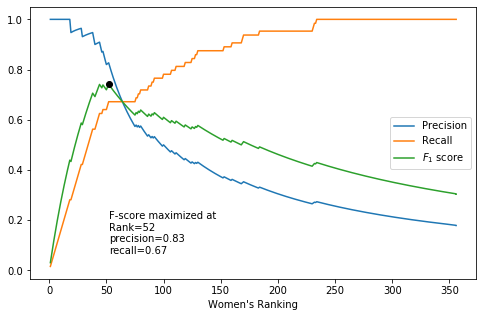

In [34]:
# Compute the false/true negatives.
fn = df_combined_plus.Womens_Field.sum()- tp
tn = (1 - df_combined_plus.Womens_Field).sum() - fp

# We use the newly computed values to compute metrics:
precision = tp/(tp + fp) + 1e-6
recall = tp/(tp + fn) + 1e-6
f_score = 2/((1/precision) + (1/recall))

# Find the place where the F-score is maximized.
f_idx = list(f_score).index(f_score.max())

# Plot metrics.
plt.figure(figsize=(8,5))
plt.plot(ranks,precision,label='Precision')
plt.plot(ranks,recall,label='Recall')
plt.plot(ranks,f_score,label='$F_1$ score')

# Mark the maximum F-score
plt.plot(ranks[f_idx],f_score[f_idx],'ok')

# Annotate the plots
plt.text(ranks[f_idx],0.02,f'F-score maximized at \nRank={ranks[f_idx]:.0f}\n' +
        f'precision={precision[f_idx]:.2f}\n' +
        f'recall={recall[f_idx]:.2f}\n')

# Label the plot.
plt.legend(loc=5);
plt.xlabel("Women's Ranking");

For the women's rankings, the ranking for Youden index is only 52, and the F-score is maximized at the same rank.